# Import des librairies utiles

In [1]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from sklearn import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from fonction_pacf import plot_sortie_acf
from scipy import stats
from pandas.tseries.offsets import MonthEnd

# Données en énergie

In [2]:
ECO_Energie=pd.read_excel("eCO2mix_RTE_energie_M.xlsx")

In [3]:
#Nettoyage des données, on ne garde que celles qui nous intéressent, on enlève les lignes qui n'ont pas de sens,
#on renomme la colonne et on transforme la colonne date en un élément "datetime"

In [4]:
ECO_Energie=ECO_Energie[ECO_Energie["Territoire"]=="France"][["Mois","Consommation totale"]]

In [5]:
ECO_Energie=ECO_Energie.iloc[1:112]

In [6]:
ECO_Energie=ECO_Energie.rename(columns={"Mois":"Date"})

In [7]:
ECO_Energie["Date"]=pd.to_datetime(ECO_Energie["Date"]) + MonthEnd()

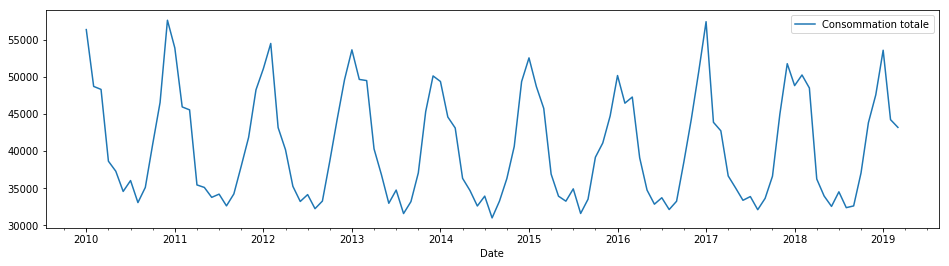

In [8]:
#première visualisation des données

ECO_Energie.set_index("Date").plot(figsize=(16,4))
#plt.savefig("Conso_base.png")

# Donnnées DJU

In [9]:
#Ensuite les DJU
DJU_data = pd.read_excel("Cegibat_DJU.xlsx", header = 9).drop(columns=["TOTAL"])

In [10]:
#Je recrée un index de date
DJU_date = pd.Series(pd.date_range(start="2010-01-01", end = "2018-12-31", freq = "M"),name="Date")

In [11]:
#Ainsi que les listes des valeurs en une grande liste
flat_list = pd.Series([item for sublist in DJU_data.values for item in sublist],name="DJU")

In [12]:
#Et j'assemble
DJU_data=pd.concat([DJU_date,flat_list], axis=1)

In [13]:
#J'assemble encore, la consommation et les DJU, avec comme clé commune la Date
#et comme il y'a des données de consommation pour lesquelles il n'y a pas de DJU, je fais un left join
CONSO_et_DJU_2010_actuel=pd.merge(ECO_Energie,DJU_data,on="Date",how="left")

In [14]:
CONSO_DJU_2010_actuel=CONSO_et_DJU_2010_actuel.copy().set_index("Date")

In [15]:
#Calcul des DJU moyens, pour remplir les données manquantes
Moy_Mensu_DJU=DJU_data[:-7].groupby(DJU_data.Date.dt.month[:-7])["DJU"].mean()

In [16]:
#remplissage données manquantes par imputation par la moyenne du mois correspondant
CONSO_DJU_2010_actuel.loc["2018-06","DJU"] = Moy_Mensu_DJU[6]
CONSO_DJU_2010_actuel.loc["2018-07","DJU"] = Moy_Mensu_DJU[7]
CONSO_DJU_2010_actuel.loc["2018-08","DJU"] = Moy_Mensu_DJU[8]
CONSO_DJU_2010_actuel.loc["2018-09","DJU"] = Moy_Mensu_DJU[9]
CONSO_DJU_2010_actuel.loc["2018-10","DJU"] = Moy_Mensu_DJU[10]
CONSO_DJU_2010_actuel.loc["2018-11","DJU"] = Moy_Mensu_DJU[11]
CONSO_DJU_2010_actuel.loc["2018-12","DJU"] = Moy_Mensu_DJU[12]
CONSO_DJU_2010_actuel.loc["2019-01","DJU"] = Moy_Mensu_DJU[1]
CONSO_DJU_2010_actuel.loc["2019-02","DJU"] = Moy_Mensu_DJU[2]
CONSO_DJU_2010_actuel.loc["2019-03","DJU"] = Moy_Mensu_DJU[3]

# Visualisations graphiques

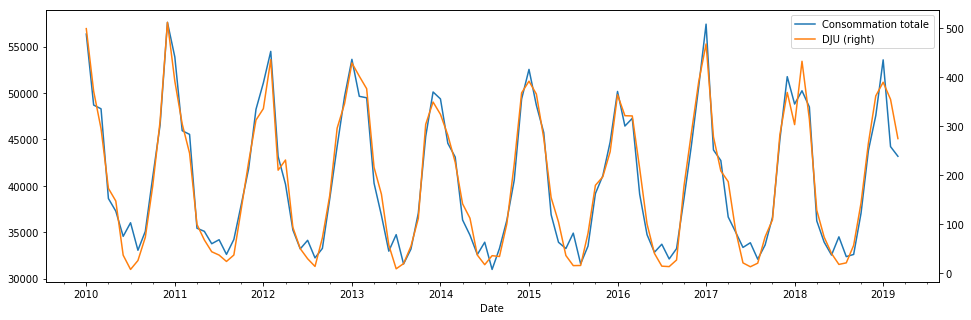

In [17]:
#visualisation de la consommation et des DJU, sur deux échelles différentes

CONSO_DJU_2010_actuel.plot(secondary_y="DJU",figsize=(16,5))
#plt.savefig("Conso_DJU_base.png")

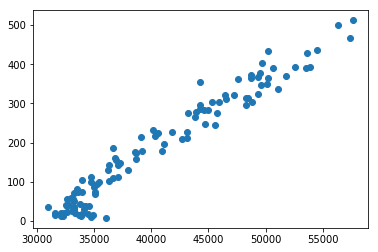

In [18]:
#un scatterplot pour mettre en évidence la corrélation entre les deux séries

plt.scatter(CONSO_DJU_2010_actuel["Consommation totale"] ,CONSO_DJU_2010_actuel["DJU"])
#plt.savefig("scatterplot_conso_dju.png")

# Régression linéaire


## Entraînement du modèle

In [19]:
Y=CONSO_DJU_2010_actuel["Consommation totale"]

In [20]:
X=np.asarray(CONSO_DJU_2010_actuel["DJU"]).reshape(-1,1)

In [21]:
reg = linear_model.LinearRegression()
reg.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [22]:
#le coefficient qui nous intéresse

reg.coef_

array([50.15883292])

In [23]:
reg.intercept_

31125.40620507924

## Correction des données grâce à la régression linéaire

In [24]:
#on soustrait la composante due aux DJU de la consommation afin de la corriger

Conso_corrigee=(CONSO_DJU_2010_actuel["Consommation totale"] - (reg.coef_*CONSO_DJU_2010_actuel["DJU"]))

In [25]:
Conso_corrigee=Conso_corrigee.rename("Conso_corrigee")

In [26]:
Conso_corrigee.index.freq="M"

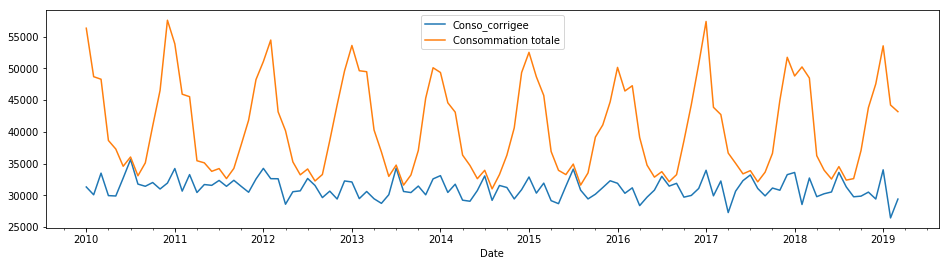

In [27]:
#on se rend compte que les valeurs de la consommation corrigée de l'effet thermique sont proches de l'intercept.
#c'est assez logique, vu qu'on cherchait a enlever cet effet thermique

Conso_corrigee.plot(figsize=(16,4))
CONSO_DJU_2010_actuel["Consommation totale"].plot()
plt.legend()
#plt.savefig("Conso_corr_reg_lin.png")

## Tests du modèle

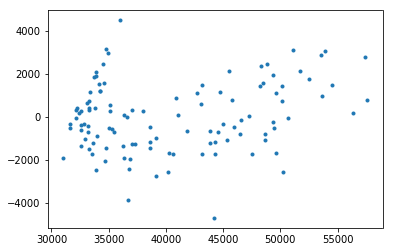

In [59]:
#Représentation des résidus
plt.plot(Y, Y-reg.predict(X),'.')
#plt.savefig("Residus_reg_lin.png")
plt.show()

In [29]:
#Test de shapiro pour vérifier la normalité des résidus
#H0 = léchantillon est issu d'une population normalement distribuée
stats.shapiro(Y-reg.predict(X))

#la valeur élevée de la p_value indique bien que l'on ne peut PAS rejeter l'hypothèse nulle, autrement dit 
#il est probable que les données observées soient normalement distribuées

(0.9921575784683228, 0.7807196378707886)

# Désaisonnalisation


In [30]:
#Avant de désaisonnaliser, nous allons directement regarder l'autocorrélograme de notre série temporelle,
#qui pourra nous aider a savoir quel type de saisonnalité nous avons.

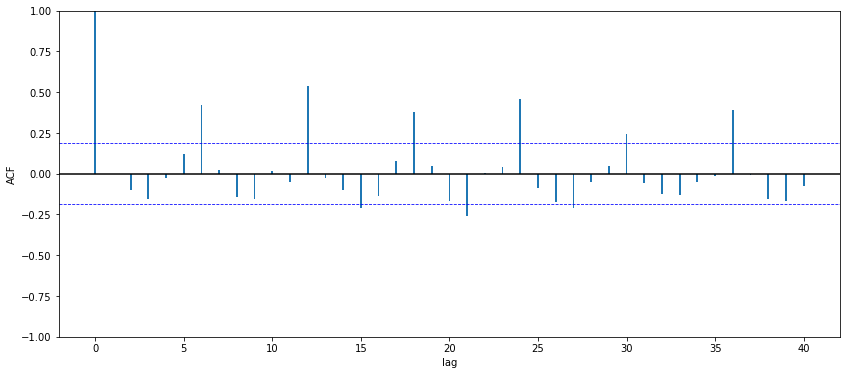

In [31]:
plot_sortie_acf(acf(Conso_corrigee),len(Conso_corrigee))
#ceci nous indique une saisonnalité de période 12
#plt.savefig("sortie_acf_conso_corr.png")

## Calculs de la moyenne mobile

In [32]:
rolling_mean = Conso_corrigee.rolling(window=12,center=True).mean()
#On calcule donc la moyenne mobile sur une période de 12

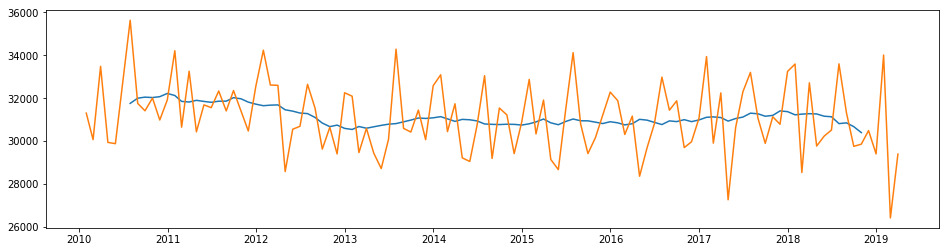

In [33]:
plt.figure(figsize=(16,4))
plt.plot(rolling_mean)
plt.plot(Conso_corrigee)
#résultats en graph
#plt.savefig("moyenne_mobile.png")

In [34]:
diff_moy_mob=(Conso_corrigee-rolling_mean)
#on va ensuite calculer la différence entre les valeurs observées et la moyenne mobile

In [35]:
#ce qui nous permet d'effectuer les calculs des coefficients saisonniers
c1 = diff_moy_mob[diff_moy_mob.index.month==1].mean()
c2 = diff_moy_mob[diff_moy_mob.index.month==2].mean()
c3 = diff_moy_mob[diff_moy_mob.index.month==3].mean()
c4 = diff_moy_mob[diff_moy_mob.index.month==4].mean()
c5 = diff_moy_mob[diff_moy_mob.index.month==5].mean()
c6 = diff_moy_mob[diff_moy_mob.index.month==6].mean()
c7 = diff_moy_mob[diff_moy_mob.index.month==7].mean()
c8 = diff_moy_mob[diff_moy_mob.index.month==8].mean()
c9 = diff_moy_mob[diff_moy_mob.index.month==9].mean()
c10 = diff_moy_mob[diff_moy_mob.index.month==10].mean()
c11 = diff_moy_mob[diff_moy_mob.index.month==11].mean()
c12 = diff_moy_mob[diff_moy_mob.index.month==12].mean()

In [36]:
#puis de la moyenne des coefficients
c_moyen = (c1 + c2 + c3 + c4 + c5 + c6 + c7 + c8 + c9 + c10 + c11 + c12)/12

In [37]:
#et enfin les calculs des coefficients saisonniers CENTRéS
c1_centre = c1 - c_moyen
c2_centre = c2 - c_moyen
c3_centre = c3 - c_moyen
c4_centre = c4 - c_moyen
c5_centre = c5 - c_moyen
c6_centre = c6 - c_moyen
c7_centre = c7 - c_moyen
c8_centre = c8 - c_moyen
c9_centre = c9 - c_moyen
c10_centre = c10 - c_moyen
c11_centre = c11 - c_moyen
c12_centre = c12 - c_moyen

In [38]:
Conso_cvs1=Conso_corrigee[Conso_corrigee.index.month==1]-c1_centre
Conso_cvs2=Conso_corrigee[Conso_corrigee.index.month==2]-c2_centre
Conso_cvs3=Conso_corrigee[Conso_corrigee.index.month==3]-c3_centre
Conso_cvs4=Conso_corrigee[Conso_corrigee.index.month==4]-c4_centre
Conso_cvs5=Conso_corrigee[Conso_corrigee.index.month==5]-c5_centre
Conso_cvs6=Conso_corrigee[Conso_corrigee.index.month==6]-c6_centre
Conso_cvs7=Conso_corrigee[Conso_corrigee.index.month==7]-c7_centre
Conso_cvs8=Conso_corrigee[Conso_corrigee.index.month==8]-c8_centre
Conso_cvs9=Conso_corrigee[Conso_corrigee.index.month==9]-c9_centre
Conso_cvs10=Conso_corrigee[Conso_corrigee.index.month==10]-c10_centre
Conso_cvs11=Conso_corrigee[Conso_corrigee.index.month==11]-c11_centre
Conso_cvs12=Conso_corrigee[Conso_corrigee.index.month==12]-c12_centre

In [39]:
Conso_cvs=pd.concat([Conso_cvs1 , Conso_cvs2 , Conso_cvs3 , Conso_cvs4 , Conso_cvs5 , Conso_cvs6 , Conso_cvs7,
           Conso_cvs8 , Conso_cvs9 , Conso_cvs10 , Conso_cvs11 , Conso_cvs12]).sort_index()

## Visualisations graphiques

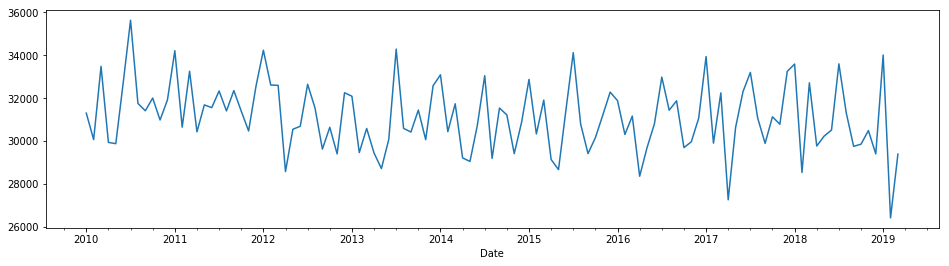

In [60]:
Conso_corrigee.plot(figsize=(16,4))
#série avant correction des variations saisonnières

#la différence n'est pas évidente a l'oeil nu mais si l'on regarde l'échelle on se rend bien compte qu'on a réduit
#la différence entre les pics et les creux
#plt.savefig("conso_corr_avant.png")

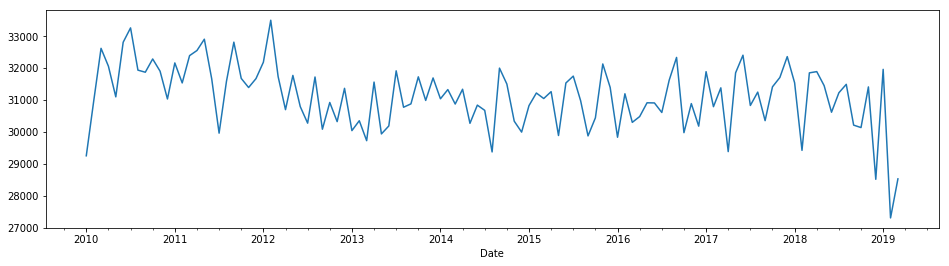

In [61]:
Conso_cvs.plot(figsize=(16,4))
#série après correction des variations saisonnières
#plt.savefig("conso_corr_apres.png")

# Forecasting


## Holt & Winters


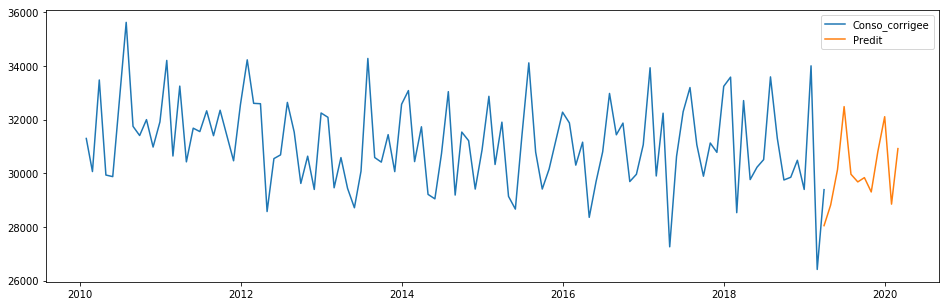

In [62]:
#Lissage exponentiel de Holt Winters , incluant une tendance ET une saisonnalité, ici de type additives.
#je continue de travailler sur la série corrigée de l'effet thermique mais pas des variations saisonnières

hw = ExponentialSmoothing(np.asarray(Conso_corrigee), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.figure(figsize=(16,5))
plt.plot(Conso_corrigee, label='Conso_corrigee')
plt.plot(pd.date_range(Conso_corrigee.index[len(Conso_corrigee)-1], periods=12, freq='M'), hw_pred, label='Predit')
plt.legend()
#plt.savefig("Predict_H&W.png")
plt.show()

## SARIMA

## Identification du modèle

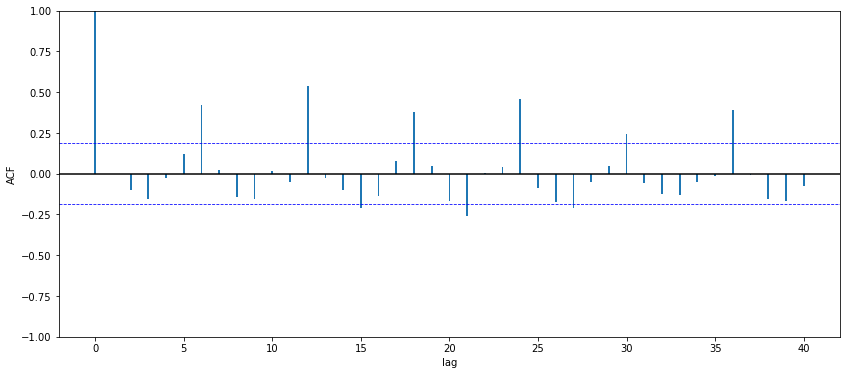

In [43]:
#On regarde encore la sortie acf

y_len = len(Conso_corrigee) # variable nécessaire pour l'utilisation de plot_sortie_acf

plot_sortie_acf(acf(np.asarray(Conso_corrigee)), y_len)

In [44]:
#différencation d'ordre 12 au vu de la saisonnalité

Conso_dif12 = Conso_corrigee - Conso_corrigee.shift(12)

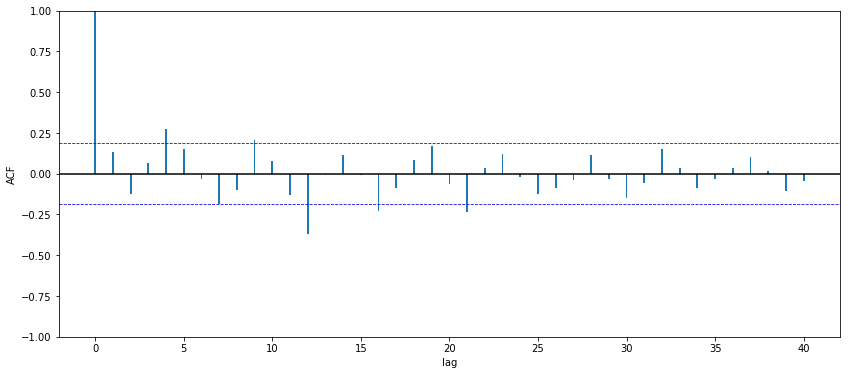

In [63]:
plot_sortie_acf(acf(Conso_dif12[12:]),y_len)
#plt.savefig("sortie_acf_diff12.png")

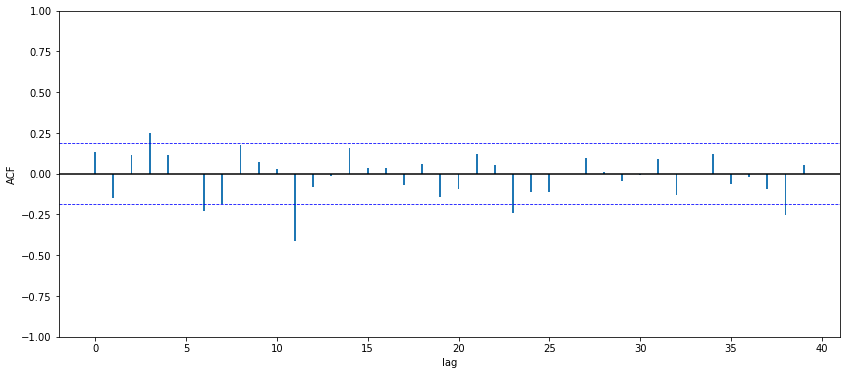

In [64]:
plot_sortie_acf(pacf(Conso_dif12[12:]),y_len,pacf=True)
#plt.savefig("sortie_pacf_diff12.png")

## Entraînement du modèle

In [47]:
#Processus MA : On considère que le processus est la résultante d'une combinaison linéaire 
#de perturbations decorrélées (un bruit blanc et son passé).

#Processus AR : La modélisation de Xt  se résume à une relation linéaire le liant aux p  derniers instants.

#Processus ARIMA : Permet de modéliser des séries temporelles qui présentent une tendance polynomiale ( non linéaire )
# => Processus non stationnaire

#Processus SARIMA : Permet de modéliser des séries temporelles qui présentent une saisonnalité
# => se ramène à l'estimation d'un modèle ARMA sur la série différenciée

In [48]:
#on utilise ensuite les lignes de code suivantes pour tester le modèle

model1 = SARIMAX(np.asarray(Conso_corrigee), order=(1,0,1), seasonal_order=(1,0,1,12))
results1 = model1.fit()
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  111
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -947.702
Date:                            Wed, 03 Jul 2019   AIC                           1905.404
Time:                                    15:24:10   BIC                           1918.952
Sample:                                         0   HQIC                          1910.900
                                            - 111                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   7.62e-06   1.31e+05      0.000       1.000       1.000
ma.L1         -0.9681      0.023   

## Prévision grâce au modèle

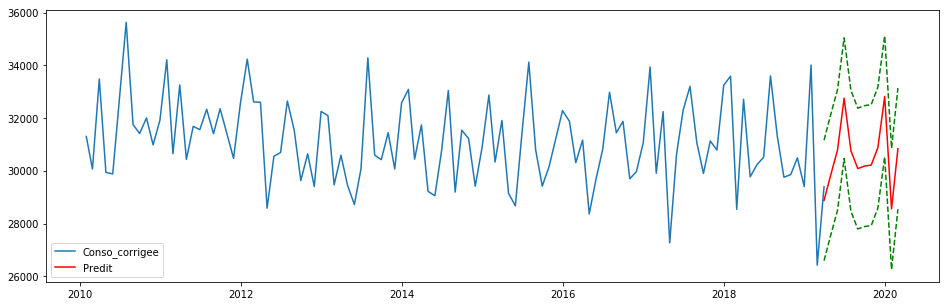

In [65]:
pred_model1 = results1.get_forecast(12)
pred = pred_model1.predicted_mean
pred_l = [elt[0] for elt in pred_model1.conf_int(alpha=0.05)]
pred_u = [elt[1] for elt in pred_model1.conf_int(alpha=0.05)]

plt.figure(figsize=(16,5))
plt.plot(Conso_corrigee)
plt.plot(pd.date_range(Conso_corrigee.index[len(Conso_corrigee)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(Conso_corrigee.index[len(Conso_corrigee)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(Conso_corrigee.index[len(Conso_corrigee)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.legend()
#plt.savefig("Predict_SARIMA.png")
plt.show()

In [50]:
from scipy.stats import shapiro

shapiro(results1.resid)

#le modèle semble performant et passe les tests de blancheur du résidu et de normalité

(0.366671621799469, 9.172497245145126e-20)

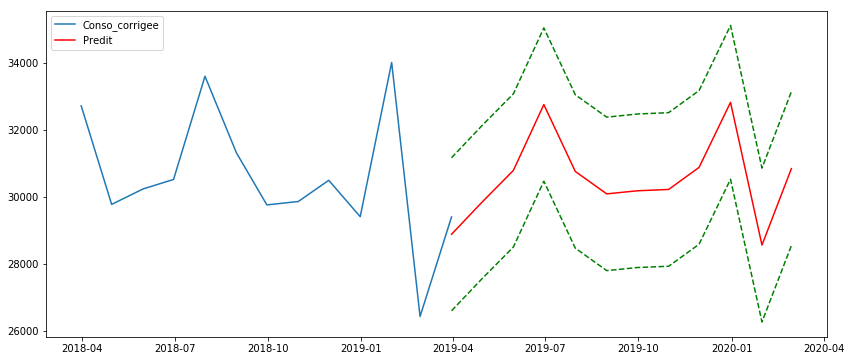

In [66]:
#on "zoome" sur la fin

plt.figure(figsize=(14,6))
plt.plot(Conso_corrigee["2018-03":], label="Conso_corrigee")
plt.plot(pd.date_range(Conso_corrigee.index[len(Conso_corrigee)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(Conso_corrigee.index[len(Conso_corrigee)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(Conso_corrigee.index[len(Conso_corrigee)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.legend()
#plt.savefig("Predict_SARIMA_zoom.png")
plt.show()

## Analyse à posteriori

In [52]:
#Analyse a posteriori : on enlève une partie des données que l'on connait déja, on fait une prédiction
#sur cette période de temps et on compare avec la réalité.

x_tronc = Conso_corrigee[:"2018-03"]
x_a_prevoir = Conso_corrigee['2018-04':]

In [53]:
#vérification de la validité du modèle sur la série tronquée

modeltronc = SARIMAX(np.asarray(x_tronc), order = (1,0,1), seasonal_order= (1,0,1,12))
resultstronc = modeltronc.fit()
print(resultstronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(resultstronc.resid, lags=elt)[1].mean()))
    
shapiro(resultstronc.resid)

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   99
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -841.973
Date:                            Wed, 03 Jul 2019   AIC                           1693.946
Time:                                    15:24:11   BIC                           1706.922
Sample:                                         0   HQIC                          1699.196
                                             - 99                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   2.94e-05   3.41e+04      0.000       1.000       1.000
ma.L1         -0.9937      0.013   

(0.34108442068099976, 4.698282481724628e-19)

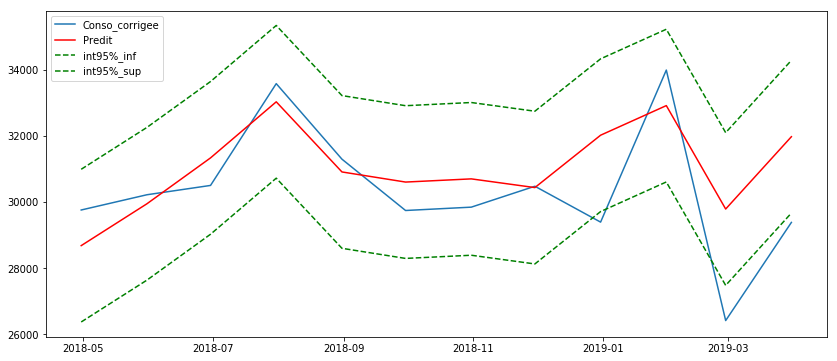

In [67]:
#comparaison entre la prédiction et la réalité

pred_modeltronc = resultstronc.get_forecast(12)
pred_tronc = pred_modeltronc.predicted_mean
pred_l_tronc = [elt[0] for elt in pred_modeltronc.conf_int(alpha=0.05)]
pred_u_tronc = [elt[1] for elt in pred_modeltronc.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Conso_corrigee')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Predit')
plt.plot(x_a_prevoir.index, pred_l_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.legend()
#plt.savefig("test_modele_posteriori.png")
plt.show()

In [55]:
#la prévision est très proche de la réalité. On conclut que le modèle est bon

## Calculs des indicateurs du modèle

In [56]:
rmse = np.sqrt(((x_a_prevoir-pred_tronc)**2).mean())
rmse

1584.1054665445336

In [57]:
#mean absolute percentage error = moyenne des écarts en valeurs absolue par rapport aux valeurs observées
mape=(np.abs(1-pred_tronc/x_a_prevoir)).mean()*100
mape

4.147831010140813

In [58]:
#les valeurs sont plus que correctes au vues des valeurs initiales